In [1]:
from jetstream_hugo.jet_finding import *
from jetstream_hugo.definitions import *
from jetstream_hugo.plots import *
from jetstream_hugo.clustering import *
from jetstream_hugo.data import *
import colormaps

%load_ext autoreload
%autoreload 2
%matplotlib inline

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:38: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/libpysal/cg/alpha_shapes.py:164: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit
/storage/homefs/hb22g102/mambaforge/envs/env1

In [2]:
from cdo import Cdo
cdo = Cdo()

In [3]:
basepath = Path(f"{DATADIR}/ERA5/thetalev")
fl1 = basepath.joinpath("u").joinpath("6H").glob("*.nc")
fl2 = basepath.joinpath("v").joinpath("6H").glob("*.nc")
for file1, file2 in tqdm(zip(fl1, fl2), total=64):
    dest_file = basepath.joinpath("s").joinpath("6H").joinpath(file1.name)
    cdo.chname(
        "u,s",
        input="-sqrt -add -sqr -selname,U "
        + file1.as_posix()
        + " -sqr -selname,V "
        + file2.as_posix(),
        output=dest_file.as_posix(),
    )

  0%|          | 0/64 [00:00<?, ?it/s]

 45%|████▌     | 29/64 [04:42<05:22,  9.22s/it]

In [2]:
exp_s = Experiment(
    "ERA5", "plev", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_s = exp_s.da
exp_u = Experiment(
    "ERA5", "plev", "u", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_u = exp_u.da
exp_v = Experiment(
    "ERA5", "plev", "v", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 250, None, None, None
)
da_v = exp_v.da
exp_s_low = Experiment(
    "ERA5", "plev", "s", "6H", (1940, 2023), [5, 6, 7, 8, 9], -60, 70, 25, 85, 700, None, None, None
)

In [26]:
to_del_path = basepath.joinpath("to_del/6H")
year = 2021
compare_against = xr.open_dataset(to_del_path.joinpath(f"{year}.nc"))
varnames = {
    'u': 'U',
    'v': 'V',
    'P': 'P',
    'PV': 'PV',}
for smallname, bigname in varnames.items():
    da1 = xr.open_dataarray(basepath.joinpath(smallname).joinpath("6H").joinpath(f"{year}.nc"))
    da2 = compare_against[bigname]
    if da1[0].min().compute(**COMPUTE_KWARGS) != da2[0].min().compute(**COMPUTE_KWARGS):
        print(smallname, bigname, year)

IndexError: index 0 is out of bounds for axis 0 with size 0

# jet finding v5 ?

In [3]:
da_s = da_s.chunk('auto')
da_u = da_u.chunk('auto')
da_v = da_v.chunk('auto')
sigma = (da_v * da_s.differentiate('lon') - da_u * da_s.differentiate('lat')) / da_s
Udsigmadn = da_v * sigma.differentiate('lon') - da_u * sigma.differentiate('lat')
criterion = Udsigmadn + sigma ** 2
with ProgressBar():
    criterion = (criterion < -50).compute(**COMPUTE_KWARGS)

[########################################] | 100% Completed | 8.66 sms


NameError: name 'gradlnzeta' is not defined

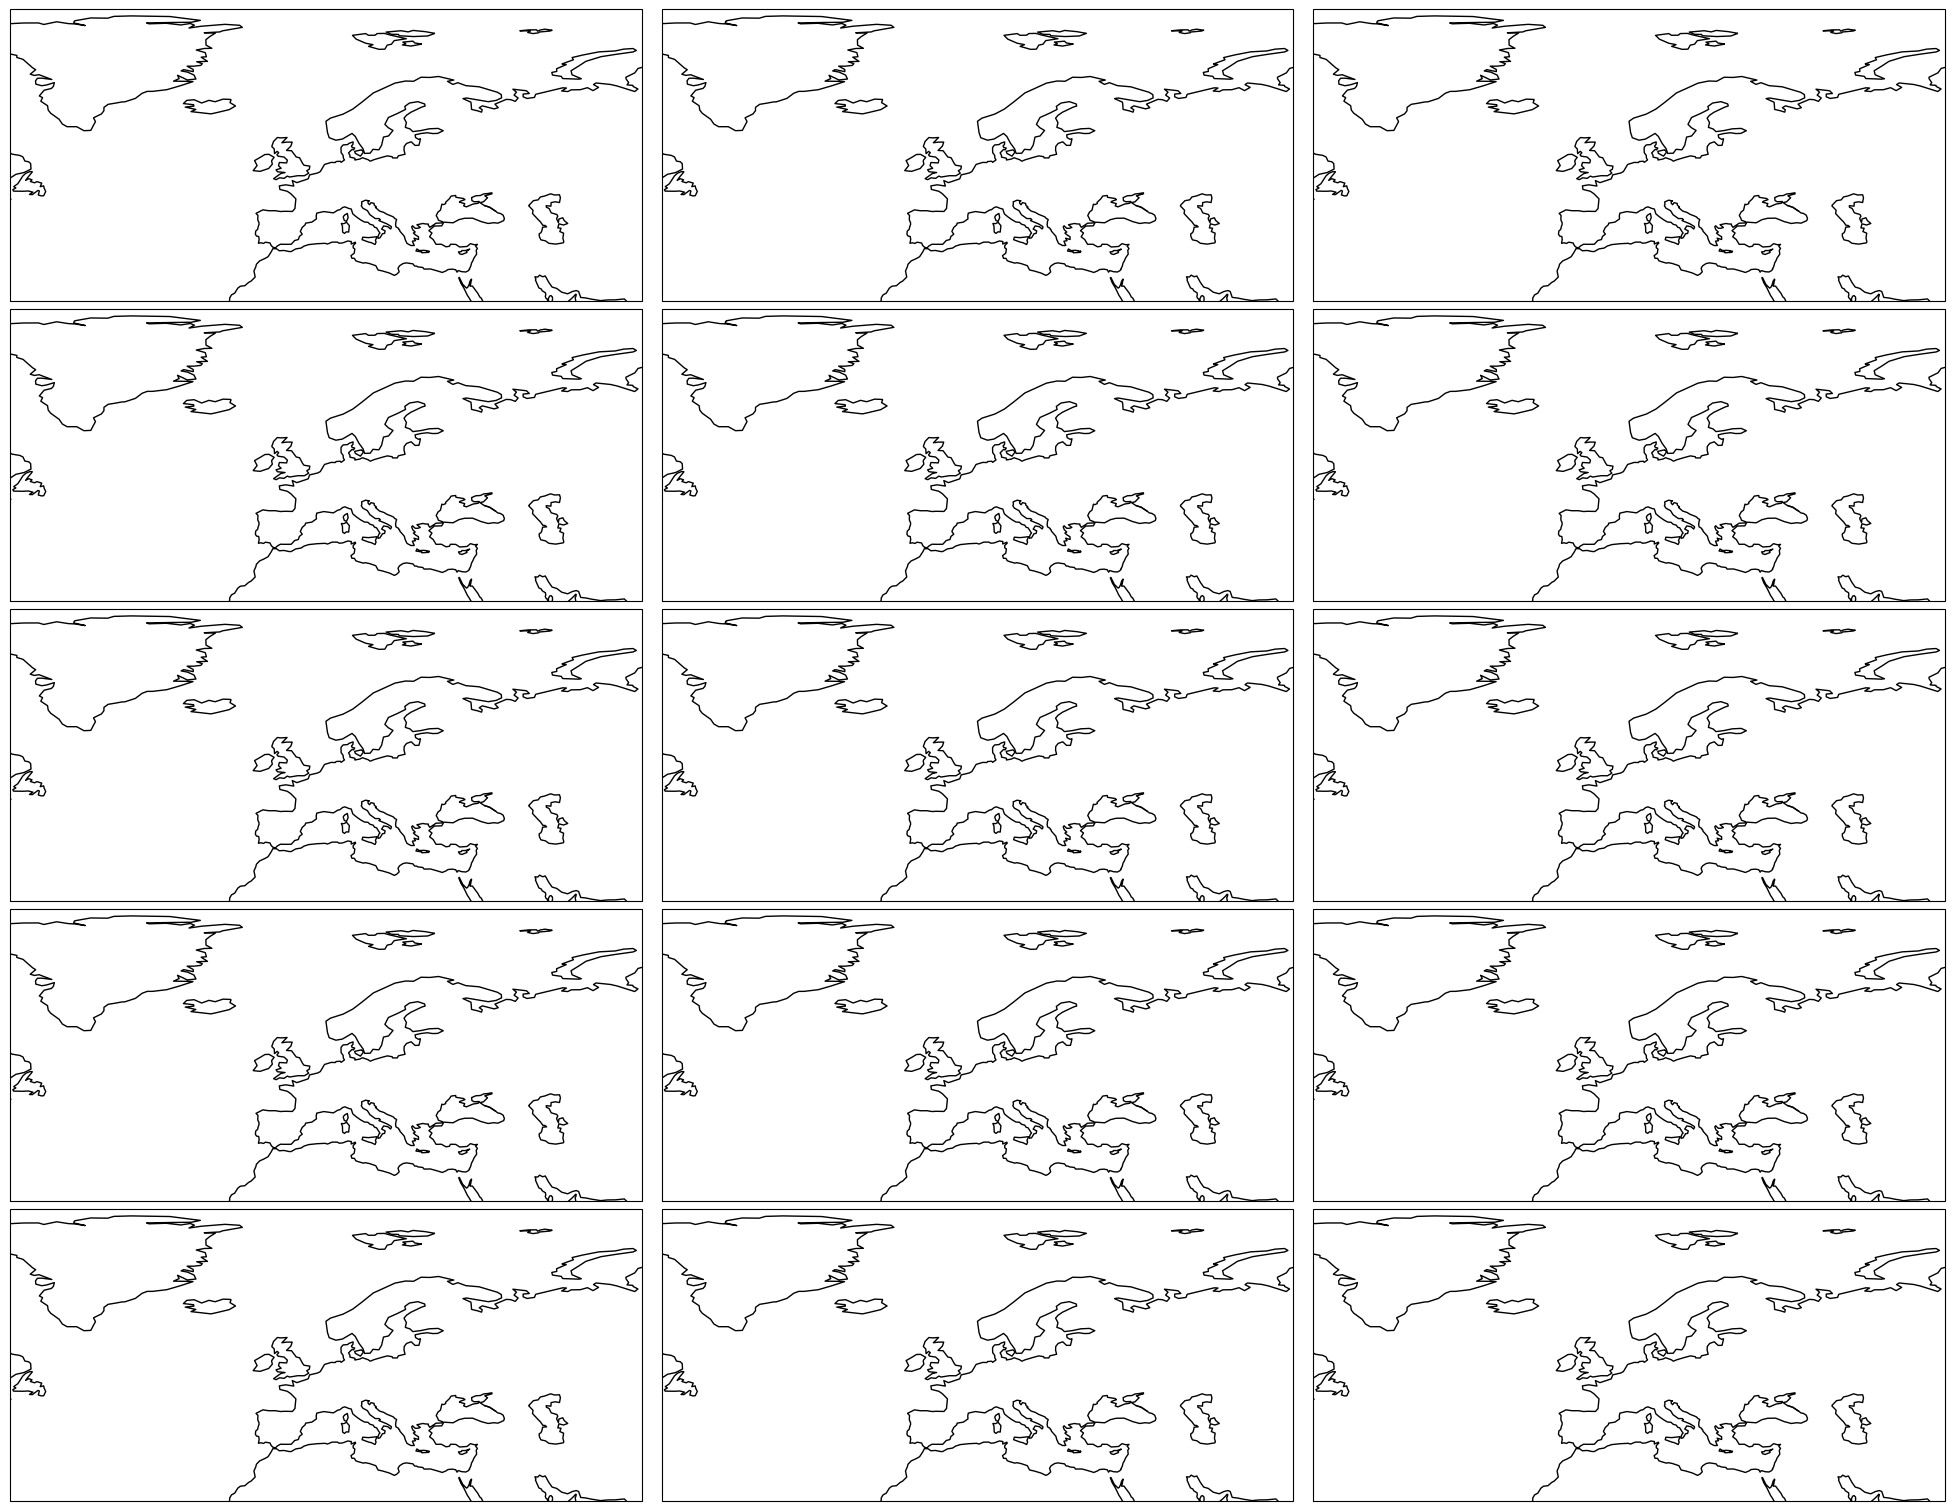

In [4]:
ncol = 5
clu = Clusterplot(ncol, 3, exp_u.region)
tsteps = np.random.randint(len(da_u), size=ncol)
lon, lat = da_s.lon.values, da_s.lat.values
crit_kwargs, _, im1, _ = clu.setup_contourf([criterion[tsteps]], transparify=1)
glz_kwargs, _, im2, _ = clu.setup_contourf([gradlnzeta[tsteps]], transparify=1, q=0.95)
s_kwargs, _, im3, _ = clu.setup_contourf([da_s[tsteps]], transparify=2, q=0.95)
clu.axes = clu.axes.reshape(ncol, 3)
for i, tstep in enumerate(tsteps):
    clu.axes[i, 0].contourf(lon, lat, criterion[tstep], **crit_kwargs)
    clu.axes[i, 1].contourf(lon, lat, gradlnzeta[tstep], **glz_kwargs)
    clu.axes[i, 2].contourf(lon, lat, da_s[tstep], **s_kwargs)
clu.fig.colorbar(im1, ax=clu.axes[:, 0])
clu.fig.colorbar(im2, ax=clu.axes[:, 1])
clu.fig.colorbar(im3, ax=clu.axes[:, 2])

# the rest

In [4]:
(
    all_jets,
    where_are_jets,
    all_jets_one_array,
    all_jets_over_time,
    flags,
) = exp_s.track_jets()
flags = xr.DataArray(flags, coords=dict(time=da_s.time.values, jet=np.arange(flags.shape[1])))
props_as_ds_uncat = exp_s.props_as_ds(categorize=False)
props_as_ds_uncat = better_is_polar(all_jets, props_as_ds_uncat, exp_s_low.path)
props_as_ds = categorize_ds_jets(props_as_ds_uncat)
props_as_np = props_to_np(props_as_ds)
props_as_ds_anoms = compute_prop_anomalies(props_as_ds)
props_as_ds["exists"] = (~props_as_ds["mean_lon"].isnull()).astype(np.float32)
normalize = lambda da: (da - da.mean(axis=0)) / da.std(axis=0)
overlaps, vert_dists = compute_all_overlaps(all_jets, props_as_ds_uncat)
da_overlaps, da_vert_dists = overlaps_vert_dists_as_da(
    da_s, all_jets, props_as_ds_uncat, exp_s.path
)
props_as_ds["overlap"] = (da_overlaps > 0).mean(dim="lon")
props_as_ds["vert_dist"] = da_vert_dists.mean(dim="lon")
da_pvs, da_pvs_anom, da_pvs_anom_normd = open_pvs(da_s)
nao_summer = get_nao(da_s)
props_as_ds["nao"] = nao_summer

100%|██████████| 51408/51408 [00:27<00:00, 1840.01it/s]


: 

## Better is_polar (WIP)

In [137]:
from sklearn.cluster import HDBSCAN, DBSCAN, KMeans, SpectralClustering
from sklearn.mixture import GaussianMixture
def to_zero_one(x):
    return (x - x.min()) / (x.max() - x.min())
props_as_ds_uncat["int_ratio"] = props_as_ds_uncat["int_low"] / props_as_ds_uncat["int"]
Lat = props_as_ds_uncat["mean_lat"].values
mask = ~np.isnan(Lat)
Lat = Lat[mask]
feature_names = ["mean_lon", "mean_lat", "int_ratio", "Spe"]
X = []
indices = np.random.randint(0, len(Lat), size=10000)
for feature_name in feature_names:
    X.append(props_as_ds_uncat[feature_name].values[mask])
X = np.stack(X).T

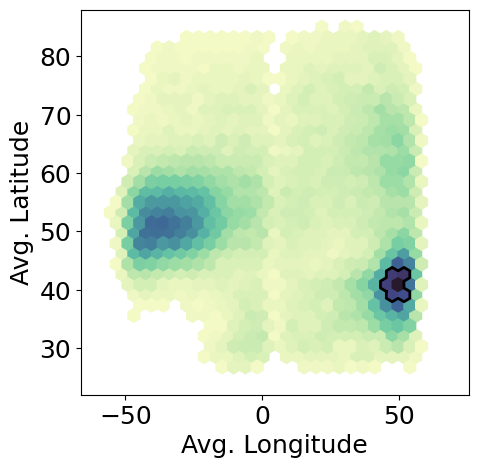

In [146]:
from shapely.geometry import Polygon
from shapely.ops import unary_union
from shapely import set_precision
fig, ax = plt.subplots(figsize=(5, 5))
feature_ind = [0, 1]
cmap = make_transparent(colormaps.deep, nlev=100, n_transparent=2)
im = ax.hexbin(*X[:, feature_ind].T, gridsize=30, cmap=cmap)
ax.set_xlabel(PRETTIER_VARNAME[feature_names[feature_ind[0]]])
ax.set_ylabel(PRETTIER_VARNAME[feature_names[feature_ind[1]]])
offsets = im.get_offsets()
counts = im.get_array()
which = counts > 0.7 * counts.max()

hex_poly = im.get_paths()[0].vertices
hex_array = []
for offs in offsets[which]:
    hex_array.append(set_precision(Polygon(hex_poly + offs[None, :]), 0.0001))
polygon = unary_union(hex_array)
try:
    plt.plot(*polygon.boundary.xy, color='black', lw=2)
except NotImplementedError:
    for geom in polygon.geoms:
        plt.plot(*geom.boundary.xy, color='black', lw=2)


## Trends

In [4]:
from numpy.polynomial import Polynomial

def p_to_tex(p: Polynomial) -> str:
    coef1 = num2tex(p.coef[1])
    coef0 = num2tex(p.coef[0])
    sign = "+" if np.sign(p.coef[0]) else "-"
    string = f"$y={coef1}\cdot x {sign} {coef0}$"
    return string

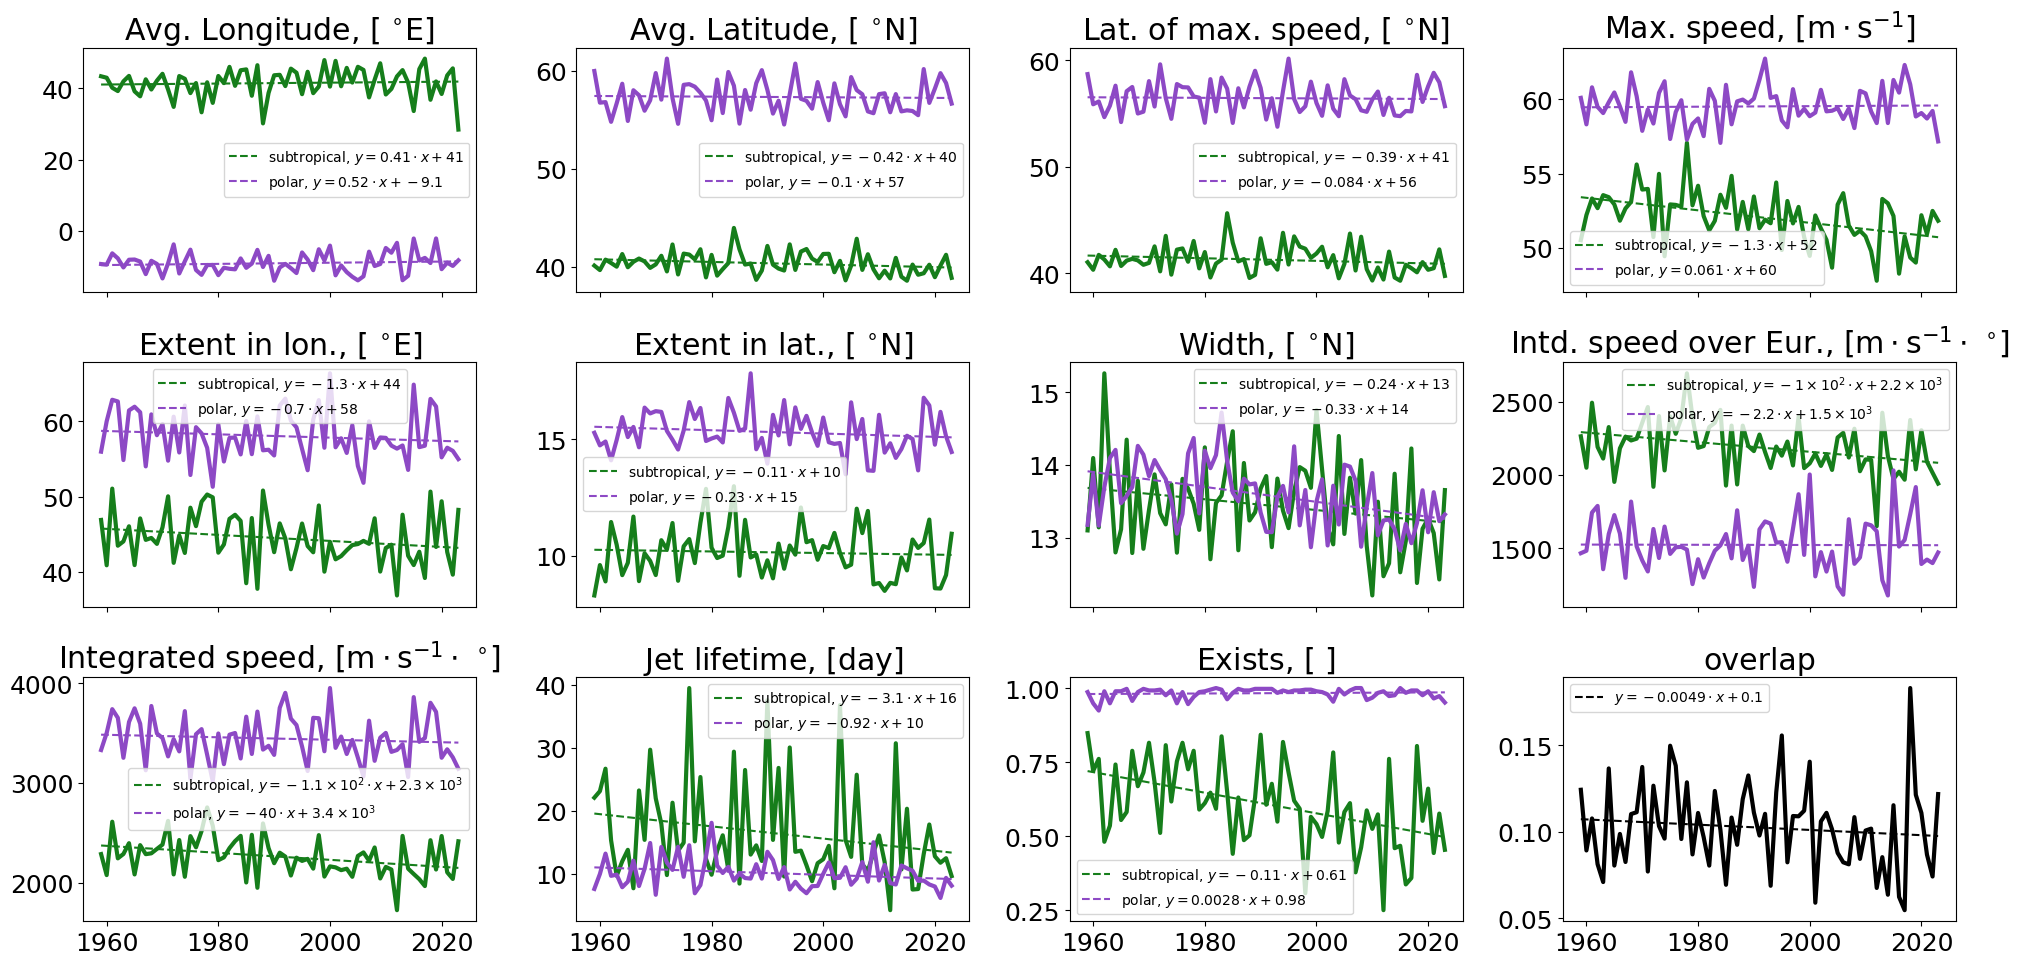

In [8]:
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
axes = axes.flatten()
high_summer_mask = np.isin(props_as_ds.time.dt.month.values, [6, 7, 8])
props_as_ds_yearly_hs = props_as_ds.sel(time=high_summer_mask).resample(time="1Y").mean()
time_mask = (props_as_ds_yearly_hs.time.dt.year >= 1959).values
time_mask = time_mask
x = props_as_ds_yearly_hs.time[time_mask].dt.year.values
data_vars = [varname for varname in props_as_ds_yearly_hs.data_vars if varname not in ["int_low", "is_polar", "Lon", "tilt", "sinuosity", "vert_dist", "nao"]]
for i, (varname, ax) in enumerate(zip(data_vars, axes)):
    for j, jet in enumerate(["subtropical", "polar"]):
        try:
            ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]") 
        except KeyError:
            ax.set_title(varname)
        try:
            this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
            ax.plot(x, this_da.values, lw=3, color=COLORS5[j])
            p = Polynomial.fit(x, this_da.values, deg=1)
            ax.plot(x, p(x), lw=1.5, color=COLORS5[j], ls="dashed", label=f"{jet}, {p_to_tex(p)}")
        except KeyError:
            this_da = props_as_ds_yearly_hs[varname][time_mask]
            ax.plot(x, this_da.values, lw=3, color="black")
            p = Polynomial.fit(x, this_da.values, deg=1)
            ax.plot(x, p(x), lw=1.5, color="black", ls="dashed", label=f"{p_to_tex(p)}")
            break
    ax.legend(ncol=1, fontsize=10)
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_yearly_trends_post_1959.png")

[[ 1.       0.41002  0.06818]
 [ 0.41002  1.      -0.18765]
 [ 0.06818 -0.18765  1.     ]]


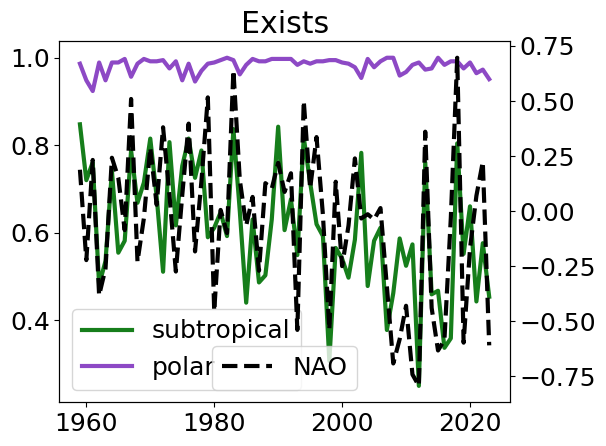

In [19]:
high_summer_mask = np.isin(props_as_ds.time.dt.month.values, [6, 7, 8])
this_props_as_ds = props_as_ds.sel(time=high_summer_mask).resample(time="1M").mean()
corr_time_mask = ~this_props_as_ds["nao"].isnull()
corrs = np.corrcoef(np.stack(
    [
        this_props_as_ds["nao"][corr_time_mask].values, 
        this_props_as_ds["exists"][corr_time_mask, 0].values, 
        this_props_as_ds["exists"][corr_time_mask, 1].values
    ]
))
fig, ax = plt.subplots(tight_layout=True)
varname = "exists"
for j, jet in enumerate(["subtropical", "polar"]):
    ax.set_title(f"{PRETTIER_VARNAME[varname]}") 
    this_da = props_as_ds_yearly_hs[varname].sel(jet=jet)[time_mask]
    ax.plot(x, this_da.values, lw=3, color=COLORS5[j], label=jet)
twinax = ax.twinx()
twinax.plot(x, props_as_ds_yearly_hs["nao"][time_mask], lw=3, color="black", label="NAO", ls="dashed")
ax.legend().set_zorder(102)
twinax.legend(loc="lower center")
print(corrs)

## Correlations

In [27]:
props_as_ds_late = props_as_ds.sel(time=props_as_ds.time.dt.year >= 1959)
props_as_ds_late["anti_pv_activity"] = ("time", ds_pvs["anti"].sum(dim=["lon", "lat"]).values)
props_as_ds_late["cycl_pv_activity"] = ("time", ds_pvs["cycl"].sum(dim=["lon", "lat"]).values)
props_as_ds_late["nao"] = nao_summer.sel(time=nao_summer.time.dt.year >= 1959)
props_as_ds_late["n_jets"] = (~props_as_ds_uncat["mean_lat"].isnull()).sum(dim="jet")

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


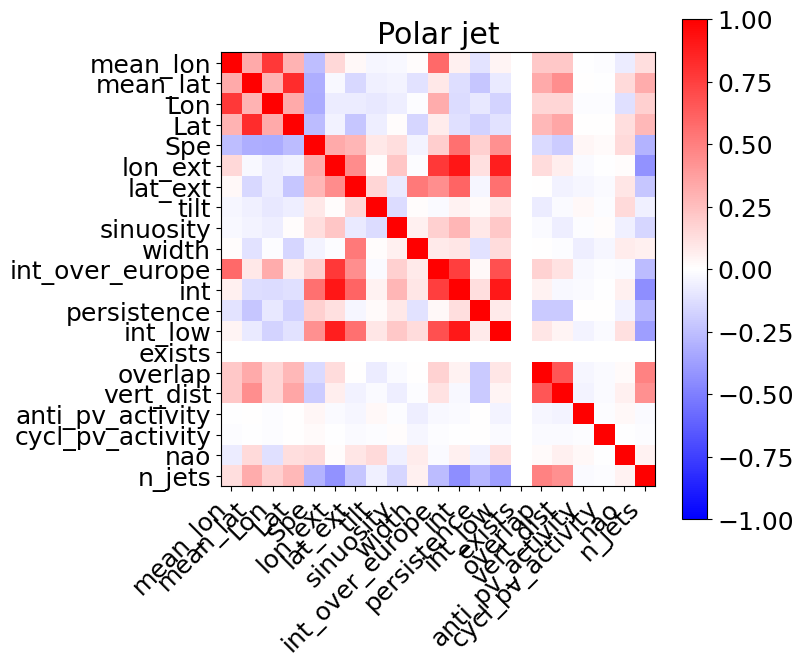

In [28]:
to_concat = []
polar_valids = ~props_as_ds_late["mean_lon"].sel(jet="polar").isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in ["anti_pv_activity", "cycl_pv_activity", "overlap", "vert_dist", "n_jets", "nao"]:
        to_concat.append(da.sel(jet="polar").values[polar_valids])
    else:
        to_concat.append(da.fillna(0).values[polar_valids])
fig, ax = plt.subplots(figsize=(7, 6.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), vmin=-1, vmax=1, cmap="bwr")
plt.colorbar(im)
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars, rotation=45, ha="right")
ax.set_title("Polar jet")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_polar.png")

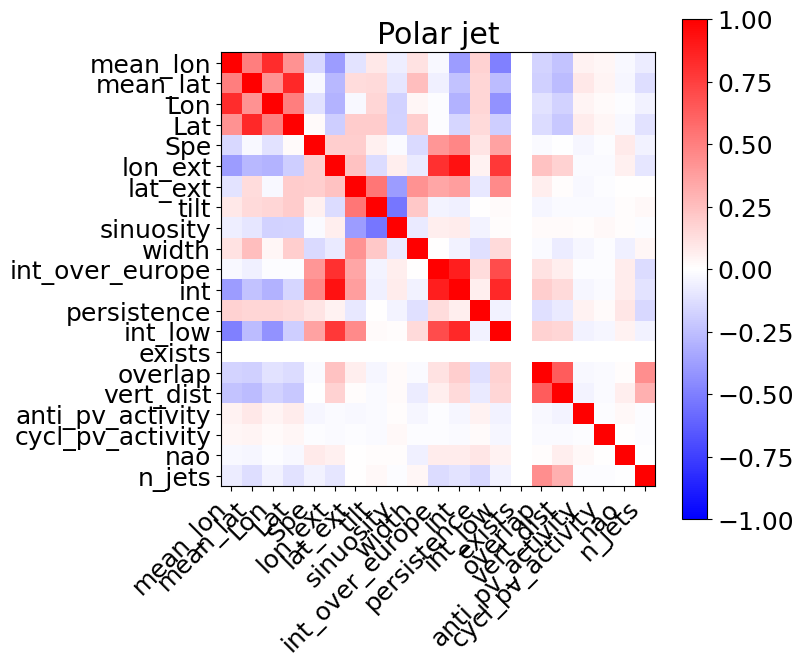

In [30]:
to_concat = []
polar_valids = ~props_as_ds_late["mean_lon"].sel(jet="subtropical").isnull().values
for varname, da in props_as_ds_late.items():
    if varname not in ["anti_pv_activity", "cycl_pv_activity", "overlap", "vert_dist", "n_jets", "nao"]:
        to_concat.append(da.sel(jet="subtropical").values[polar_valids])
    else:
        to_concat.append(da.fillna(0).values[polar_valids])
fig, ax = plt.subplots(figsize=(7, 6.5))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), vmin=-1, vmax=1, cmap="bwr")
plt.colorbar(im)
ax.set_yticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars)
_ = ax.set_xticks(np.arange(0, len(props_as_ds_late.data_vars)), props_as_ds_late.data_vars, rotation=45, ha="right")
ax.set_title("Polar jet")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_subtropical.png")

/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/lib/function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/storage/homefs/hb22g102/mambaforge/envs/env11/lib/python3.11/site-packages/numpy/lib/function_base.py:2855: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


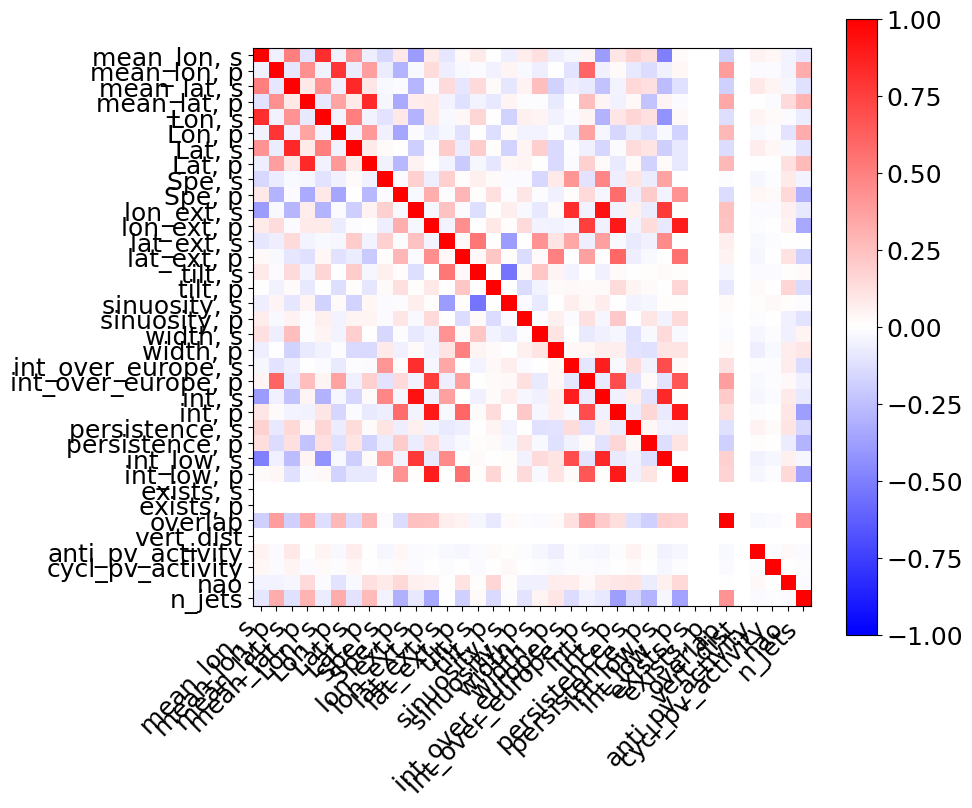

In [31]:
to_concat = []
ticks = []
valids = props_as_ds_late["mean_lon"]
valids = (~valids.sel(jet="polar").isnull() & ~valids.sel(jet="subtropical").isnull()).values
for varname, da in props_as_ds_late.items():
    if varname not in ["anti_pv_activity", "cycl_pv_activity", "overlap", "vert_dist", "n_jets", "nao"]:
        for jet in da.jet.values:
            to_concat.append(da.sel(jet=jet).values[valids])
            ticks.append(f"{varname}, {jet[0]}")
    else:
        to_concat.append(np.roll(da.values[valids], 0))
        ticks.append(varname)
fig, ax = plt.subplots(figsize=(9, 8))
im = plt.imshow(np.corrcoef(np.stack(to_concat)), vmin=-1, vmax=1, cmap="bwr")
plt.colorbar(im)
ax.set_yticks(np.arange(0, len(ticks)), ticks)
_ = ax.set_xticks(np.arange(0, len(ticks)), ticks, rotation=45, ha="right")
fig.savefig(f"{FIGURES}/jet_props_misc/jet_props_corr_full.png")

## Overlaps vs absolute lon / lat

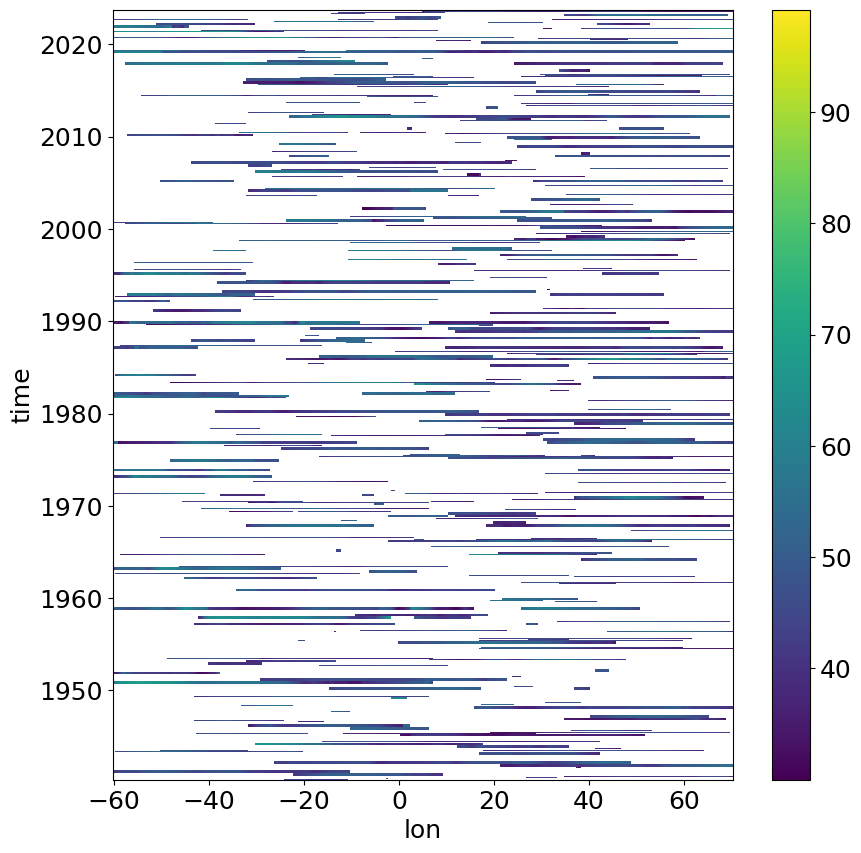

In [11]:
da_overlaps.plot(figsize=(10, 10))

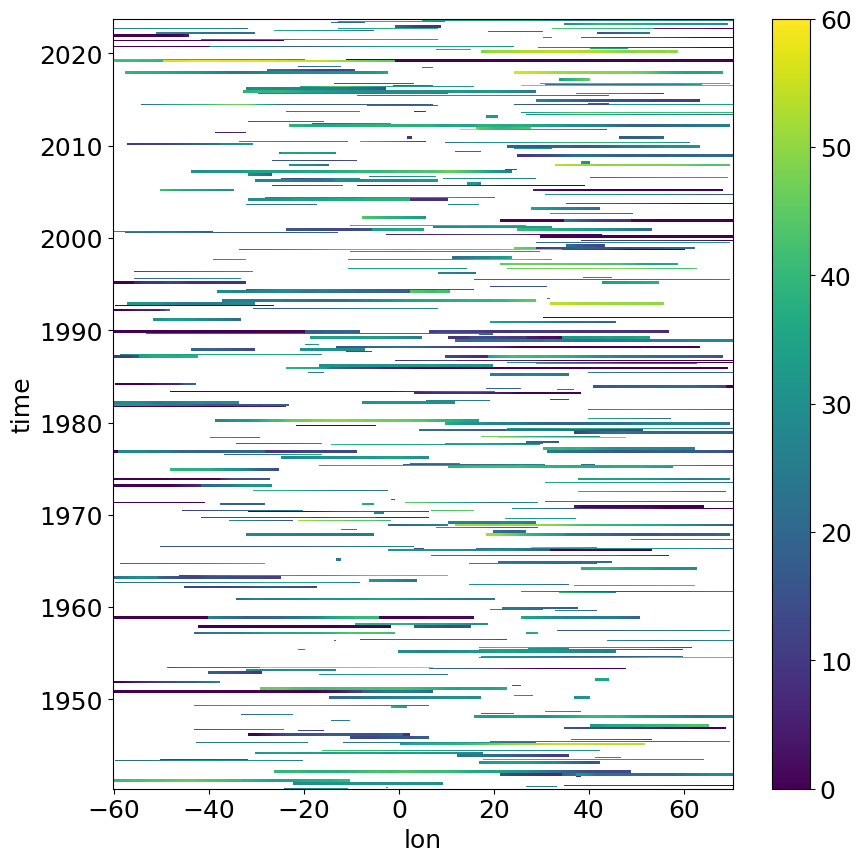

In [12]:
da_vert_dists.plot(figsize=(10, 10))

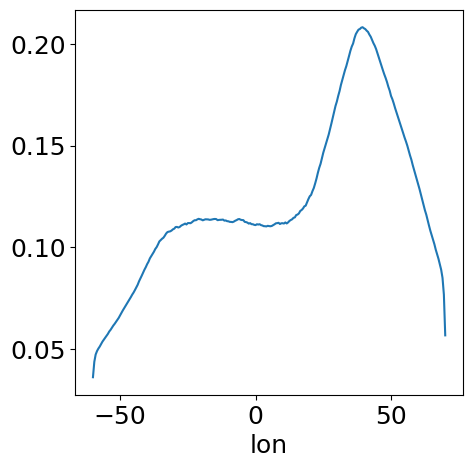

In [13]:
(da_overlaps > 0).mean(dim='time').plot(figsize=(5, 5))

## Seasonal variability ?

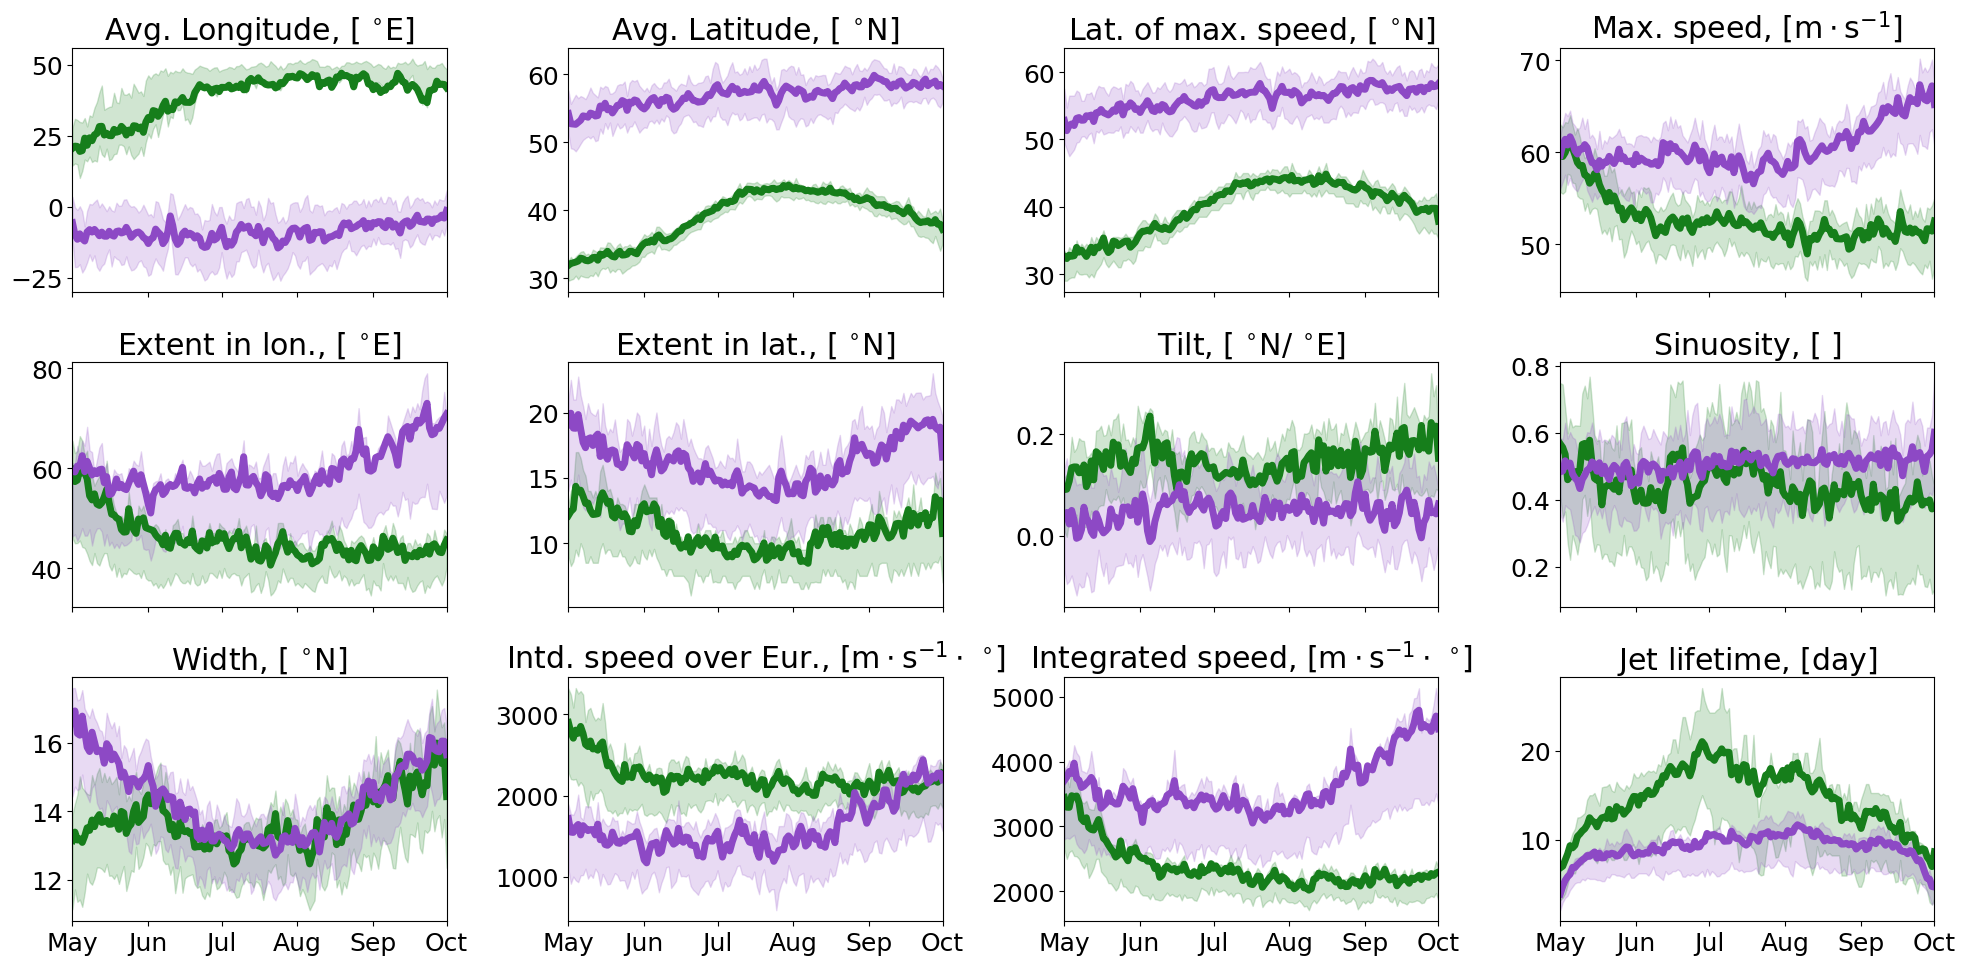

In [10]:
from matplotlib.dates import DateFormatter
data_vars = [varname for varname in props_as_ds.data_vars if varname not in ["int_low", "is_polar", "Lon"]]
fig, axes = plt.subplots(3, 4, figsize=(20, 10), tight_layout=True, sharex="all")
for varname, ax in zip(data_vars, axes.ravel()):
    gb = props_as_ds[varname].groupby("time.dayofyear")
    x = list(gb.groups.keys())
    x = DATERANGEPL_EXT[x]
    ys = gb.mean().values
    qs = gb.quantile(q=[0.33, 0.66]).values
    for i in range(2):
        ax.fill_between(x, qs[:, i, 0], qs[:, i, 1], color=COLORS5[i], alpha=0.2)
        ax.plot(x, ys[:, i], lw=5, color=COLORS5[i])
    ax.set_title(f"{PRETTIER_VARNAME[varname]}, [{UNITS[varname]}]") 
    ax.xaxis.set_major_formatter(DateFormatter("%b"))
    ax.set_xlim(min(x), max(x))
plt.savefig(f"{FIGURES}/jet_props_misc/jet_props_seasonal.png")

# Demo: double anim

In [ ]:
r1 = len(da_s.lon) / len(da_s.lat)
r2 = 1
height = 4
wspace = 0.04
cbar_size = 0.05
fig = plt.figure(
    figsize=(height * (r1 + r2 + 2 * cbar_size + 3 * wspace), height), dpi=90
)
gs = GridSpec(
    1,
    5,
    width_ratios=(r1, cbar_size, 4 * wspace, r2, cbar_size),
    wspace=0.02,
    figure=fig,
)

fig.add_subplot(gs[2], visible=False)
ax_contourf = fig.add_subplot(gs[0], projection=ccrs.PlateCarree())
ax_contourf.set_extent(
    exp_s.region,
    crs=ccrs.PlateCarree(),
)
ax_contourf.add_feature(COASTLINE)
cs = ax_contourf.contourf(
    da_s.lon.values, da_s.lat.values, da_s[tsteps[0]].values, **kwargs_contourf
)
cax = fig.add_subplot(gs[1])
fig.colorbar(cs, cax=cax)

ax_trajectory = fig.add_subplot(gs[3])
# ax_trajectory.plot([1, 2])
kwargs_trajectory = dict(
    cmap=mpl.colormaps["gray_r"], norm=Normalize(np.amin(thesepops), np.amax(thesepops))
)
xlims = [
    np.amin(coords[~outermask][:, 0]) - 0.8,
    np.amax(coords[~outermask][:, 0]) + 0.8,
]
ylims = [np.amin(coords[~outermask][:, 1]) - 1, np.amax(coords[~outermask][:, 1]) + 1]
fig, ax_trajectory = splots.plot_map(
    coords,
    populations,
    "hexagons",
    draw_cbar=False,
    show=False,
    edgecolors="black",
    cmap="Greys",
    alphas=alphas,
    linewidths=0,
    fig=fig,
    ax=ax_trajectory,
)
cax = fig.add_axes([0.67, 0.84, 0.06, 0.04])
im = ScalarMappable(**kwargs_trajectory)
fig.colorbar(im, cax=cax, orientation="horizontal", ticks=[])
cax.text(-5, 0.35, "0", ha="center", va="center")
max_pop = np.amax(populations)
cax.text(max_pop + 9, 0.35, f"{max_pop}", ha="center", va="center")

lc = LineCollection(segments, cmap="magma", norm=norm)
lc.set_array(np.repeat(np.arange(len(traj) - 1), repeats=reps))
lc.set_linewidth(3)
lc = ax_trajectory.add_collection(lc)
cax = fig.add_subplot(gs[4])
cbar = fig.colorbar(lc, label=f"Days of summer {YEARSPL[yearidx]}", cax=cax)
list_of_days = np.asarray([0, 14 * 4, 30 * 4, 44 * 4, 61 * 4, 75 * 4, 91 * 4 + 3])

pretty_list_of_days = da.time[yearidx * 92 * 4 + list_of_days].dt.strftime("%b %d").values
cbar.ax.set_yticks(list_of_days, labels=pretty_list_of_days)
cbar.ax.invert_yaxis()
ax_trajectory.set_xlim(xlims)
ax_trajectory.set_ylim(ylims)

jets = all_jets[tsteps[0]]
lines = []
for j in range(3):
    try:
        jet = jets[j]
        x, y, s = jet.T
        p = np.polyfit(x, y, w=s, deg=3, full=False)
        p = np.poly1d(p)
        newy = p(x)
    except IndexError:
        x, newy, s = [], [], []

    lines.append(ax_contourf.plot(x, newy, color='dimgray', lw=4)[0])


def animate(i):
    global cs
    global lines
    global lc
    for c in cs.collections:
        c.remove()
    cs = ax_contourf.contourf(
        da_s.lon.values, da_s.lat.values, da_s[tsteps[i]].values, **kwargs_contourf
    )
    jets = all_jets[tsteps[i]]
    for j in range(3):
        try:
            jet = jets[j]
            x, y, s = jet.T
        except IndexError:
            x, y, s = [], [], []
        lines[j].set_data(x, y)
    if i > 1:
        to_be_set_visible = np.sum(reps[:i])
        lws = np.zeros(len(segments))
        lws[:to_be_set_visible] = 4
        lc.set_lw(lws)
    else:
        lc.set_lw(0.0)
    fig.suptitle(titles[i])
    return cs, lines, lc


ani = FuncAnimation(fig, animate, frames=np.arange(len(tsteps)))
ani.save("Figures/double_anim.gif", dpi=200, fps=5)


# Demo: simple anim

MovieWriter ffmpeg unavailable; using Pillow instead.


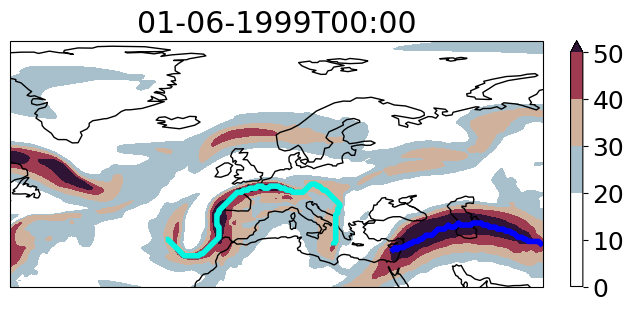

In [29]:
from matplotlib.collections import LineCollection
from matplotlib.animation import FuncAnimation

clu = Clusterplot(1, 1, exp_s.region)
fig = clu.fig
ax = clu.axes[0]
year = 1999
times = da_s.time
mask = ((times.dt.season == 'JJA') & (times.dt.year == year)).values
indices = np.where(mask)[0]
jets = all_jets[indices[0]:indices[-1]] # janky
times = times[mask]
flags_ = flags.loc[times].values
minflag, maxflax = flags_.min(), flags_[flags_ < 13000].max()
COLORS = colormaps.BlAqGrYeOrReVi200(np.linspace(0, 1, maxflax - minflag + 1))
flags_ -= minflag
kwargs_contourf, _, _, _ = clu.setup_contourf([da_s.loc[times[0]]], transparify=2, q=0.95)
lines = []
for jet in jets[0]:
    lines.append(jet[:, :2])
lc = LineCollection(lines, lw=4)
cs = ax.contourf(
    da_s.lon.values, da_s.lat.values, da_s.loc[times[0]].values, **kwargs_contourf
)
ax.add_collection(lc)
cbar = fig.colorbar(cs, ax=ax)

def animate(i):
    global lc
    global cs
    for c in cs.collections:
        c.remove()
    lines = []
    colors = []
    for jet, flag in zip(jets[i], flags_[i]):
        lines.append(jet[:, :2])
        colors.append(COLORS[flag])
    lc.set_segments(lines)
    lc.set_colors(colors)
    cs = ax.contourf(
        da_s.lon.values, da_s.lat.values, da_s.loc[times[i]].values, **kwargs_contourf
    )
    ax.set_title(times[i].dt.strftime('%d-%m-%YT%H:00').item())
    return lc, cs

ani = FuncAnimation(fig, animate, frames=len(times) - 1)
# ani = FuncAnimation(fig, animate, frames=3)
ani.save("Figures/jet_anim.gif", dpi=200, fps=2)

In [26]:
times[0].dt.strftime('%d-%m-%YT%H:00').item()

'01-06-1999T00:00'